# BlocPower: Energy consumption of public buildings in New York
## Management Summary
- A predictive model for energy costs/m2 from a few known parameters of buildings has been established
- A set of buildings with substantially higher energy costs than expected has been identified for immeditate investigation

## Demo of Jupiter Notebook on DSX with BlocPower dataset
- Ingest data from Object Storage and dashDB
- Data Exploration & Visualization
- Predictive model in base R
- Predictive model in SparkR

### Read data from Object Storage
DSX provides tailored code snippets for data intake. These handle authentication/authorization and actual data access. These cells are usually marked 'hidden' such that published notebooks don't leak sensitive information.

DSX code snippet and custom function to simplify access to ObjectStorage files

In [1]:
# The code was removed by DSX for sharing.

### Custom function for data access 

In [2]:
        
# custom function to simplify access to ObjectStorage files
getObjectStorageFileAsRdataframe <- function(container, file) {
    getObjectStorageFileWithCredentials_3015d4633bf74b6687297995308a890f(container,file)
}

In [3]:
bp <-  read.csv(file = getObjectStorageFileAsRdataframe("WDPDSX", "BP-lm.csv"))
class(bp)


Loading required package: httr
Loading required package: RCurl
Loading required package: bitops

Attaching package: ‘RCurl’

The following object is masked from ‘package:SparkR’:

    base64



[1] "data.frame"

### Data structure

In [4]:
str(bp)
head(bp)

'data.frame':	93 obs. of  11 variables:
 $ Costsm2       : num  8.07 27.01 2.59 5.17 8.7 ...
 $ Age           : int  62 77 97 52 53 53 107 120 86 86 ...
 $ Stores        : int  4 1 2 1 2 2 3 2 2 1 ...
 $ Size          : int  14600 600 6000 5000 26318 26318 3024 3800 2400 3128 ...
 $ acPlugLoad    : num  11.65 32.77 2.35 4.62 7.11 ...
 $ acAirCondition: num  0.984 5.008 0.296 0.765 1.863 ...
 $ gasDomestic   : num  0.0962 0.1858 0.0327 0.0275 0.0292 ...
 $ gasHeating    : num  0.3662 0.0296 0.0365 0.2347 0.5607 ...
 $ kWH           : num  117870 16207 15564 25851 228985 ...
 $ Long          : num  -73.9 -73.9 -74.1 -73.7 -73.9 ...
 $ Lat           : num  40.8 40.7 40.6 40.6 40.6 ...


Costsm2,Age,Stores,Size,acPlugLoad,acAirCondition,gasDomestic,gasHeating,kWH,Long,Lat
8.073288,62,4,14600,11.651406,0.9835313,0.09622646,0.36619324,117870,-73.94733,40.79192
27.011666,77,1,600,32.769884,5.0083719,0.18584352,0.02961357,16207,-73.89331,40.72744
2.594000,97,2,6000,2.345049,0.2961338,0.03270597,0.03646070,15564,-74.09870,40.64298
5.170200,52,1,5000,4.618817,0.7651886,0.02750427,0.23466382,25851,-73.74700,40.62267
8.700699,53,2,26318,7.108797,1.8631277,0.02915642,0.56072095,228985,-73.90963,40.61887
8.700699,53,2,26318,7.108797,1.8631277,0.02915642,0.56072095,228985,-73.90963,40.61887


### Location of buildings

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=40.690827,-73.819892&zoom=10&size=640x640&scale=2&maptype=terrain&sensor=false


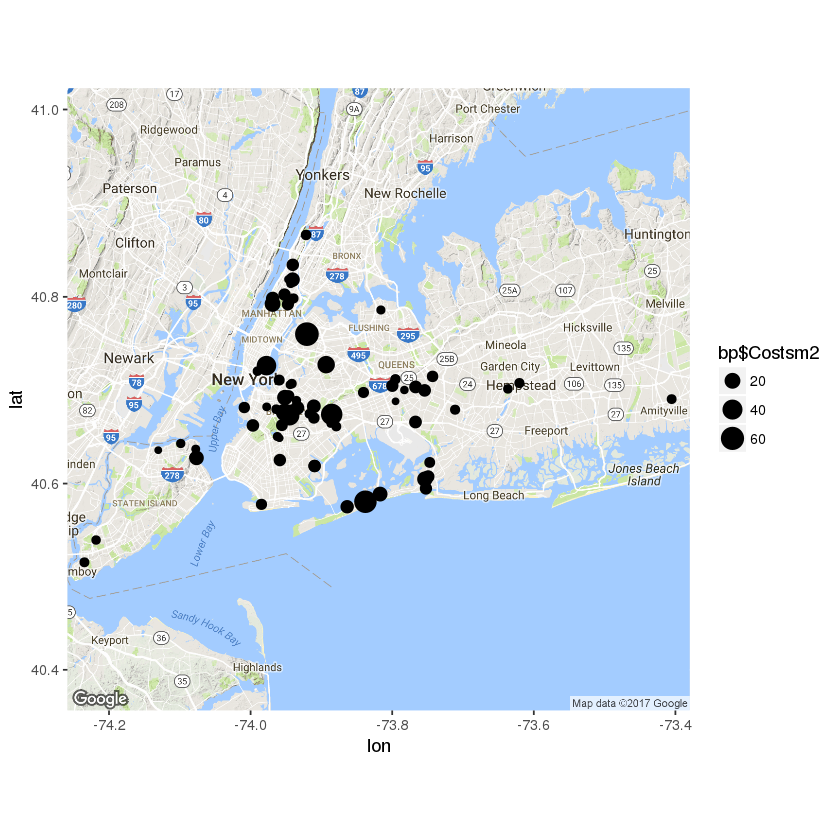

In [5]:
library(ggplot2)
library(ggmap)
library(GGally)
library(ggrepel)

c.Lat <- (max(bp$Lat)-min(bp$Lat))/2 + min(bp$Lat)
c.Long <- (max(bp$Long)-min(bp$Long))/2 + min(bp$Long)

p <- ggmap(get_googlemap(center=c(c.Long, c.Lat), zoom=10))
p <- p +  geom_point(data=bp, aes(x = Long, y = Lat, size=bp$Costsm2))
p

### Data visualization
Enhanced Scatter Plot: Uni- and Bivariate exploration

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


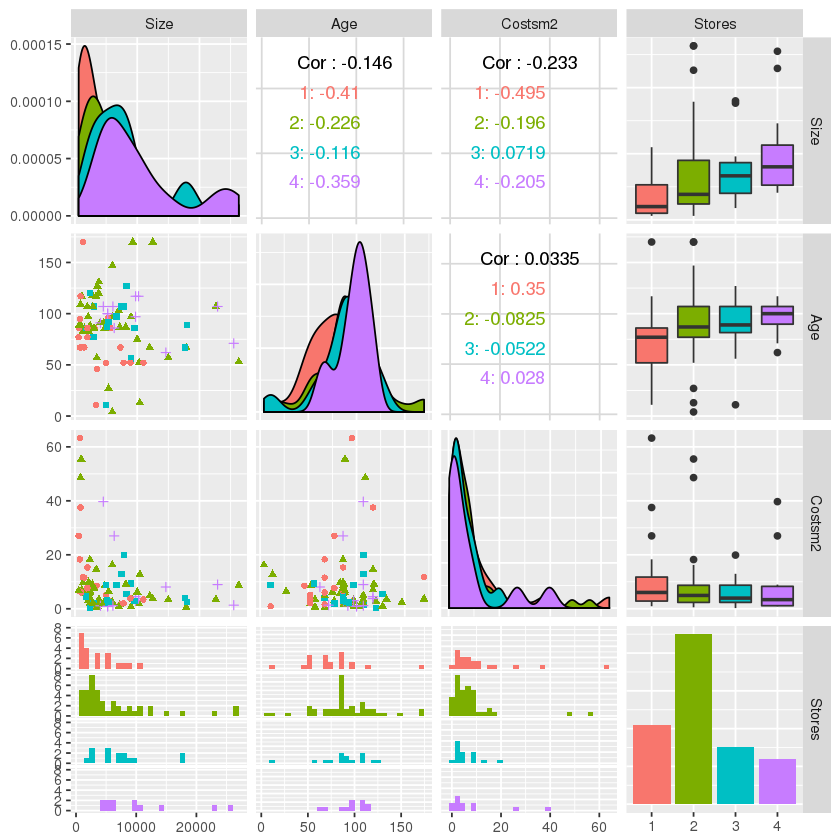

In [6]:
bpc <- c("Size", "Age", "Costsm2", "Stores")
bp$Stores<-factor(bp$Stores)
ggpairs(bp, columns=bpc, aes(col=Stores, shape=Stores), lower = list(continuous = wrap("points", size=1.5)))

# Supervised Learning: Predictive Model for Energy Costs per m2

The idea here is to predict the costs/m2 from a set of known features of each building, including it's age, size and consumption of electricity and gas. For simplicity a linear model is used, with calculations first run locally, then on the DSX Sparc cluster.

## Machine Learning with base R: Linear Model with lm()
The standard method in R for calculation of a linear model is method 'lm'. A popular method for model refinement is the 'step' procedure which systematically eliminates unsignificant features. As is always the case for 'leased square' based algorithms like 'lm', special attention needs to be paid to outliers, that is, data that is not normally distributed.

### First model with all features
The result table highlights the important features by an increasing number of stars (up to three). Note the 'predicitve power'(aka 'R-squared') of the model is around 0.8 (not too good)

In [7]:
bp <-  read.csv(file = getObjectStorageFileAsRdataframe("WDPDSX", "BP-lm.csv"))
selCols <- c("Costsm2","Age","Stores","Size","acPlugLoad","acAirCondition","gasDomestic","gasHeating","kWH")
bp.lm <- bp[,selCols]
lm <- lm(Costsm2 ~., data=bp.lm)
summary(lm)


Call:
lm(formula = Costsm2 ~ ., data = bp.lm)

Residuals:
    Min      1Q  Median      3Q     Max 
-14.437  -2.214  -0.526   1.661  35.346 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     1.461e+00  2.610e+00   0.560 0.576953    
Age             3.650e-02  1.981e-02   1.843 0.068892 .  
Stores         -1.175e+00  6.463e-01  -1.819 0.072551 .  
Size           -4.298e-04  1.486e-04  -2.891 0.004881 ** 
acPlugLoad      8.564e-01  9.060e-02   9.453 7.28e-15 ***
acAirCondition -2.982e-01  5.889e-01  -0.506 0.613897    
gasDomestic     2.380e+00  3.355e+00   0.709 0.480054    
gasHeating     -1.279e+00  1.371e+00  -0.933 0.353507    
kWH             6.747e-05  1.801e-05   3.746 0.000328 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.209 on 84 degrees of freedom
Multiple R-squared:  0.8066,	Adjusted R-squared:  0.7881 
F-statistic: 43.78 on 8 and 84 DF,  p-value: < 2.2e-16


### Model refinement
As several features are not flagged important it makes sense to eliminate these (following the 'Principle of Parsimony'). Note that the explanatory power of the model does not increase.

In [8]:
lms <- step(lm, trace=0)
summary(lms)


Call:
lm(formula = Costsm2 ~ Age + Stores + Size + acPlugLoad + kWH, 
    data = bp.lm)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.465  -2.328  -0.454   1.369  35.456 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.645e-02  2.119e+00  -0.012 0.990070    
Age          4.394e-02  1.839e-02   2.389 0.019060 *  
Stores      -1.188e+00  6.364e-01  -1.866 0.065368 .  
Size        -3.838e-04  1.326e-04  -2.895 0.004792 ** 
acPlugLoad   8.546e-01  6.614e-02  12.921  < 2e-16 ***
kWH          6.153e-05  1.649e-05   3.732 0.000338 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.158 on 87 degrees of freedom
Multiple R-squared:  0.8036,	Adjusted R-squared:  0.7923 
F-statistic: 71.17 on 5 and 87 DF,  p-value: < 2.2e-16


### Model critic
Check for outliers: how much do actual values differ from the predicted values ?

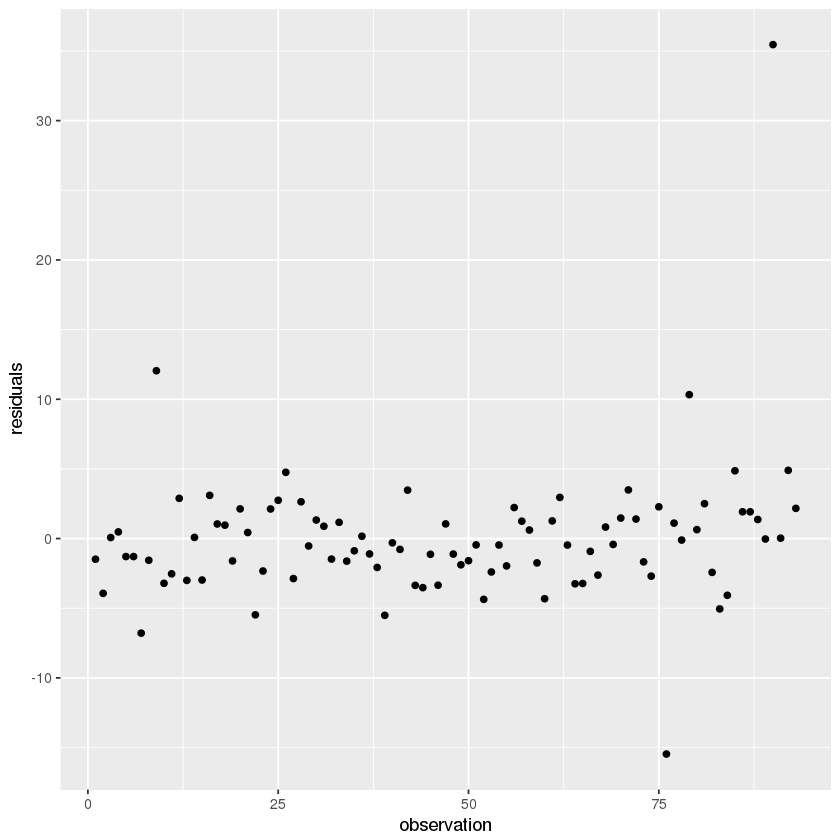

In [9]:
df <- data.frame(observation=1:length(resid(lms)), residuals=resid(lms))
ggplot(data=df, aes(observation,residuals)) + geom_point()

### Remove outliers
Note that the explanatory power of the model increases significantly with four outliers removed (R-squared = percentage of explained variance increases from 0.8 to around 0.94)

In [10]:
outliers <- which(abs(resid(lms))>10)

bp.lm.no <- bp.lm[-outliers,]
lms2 <- step(lm(Costsm2~., data=bp.lm.no), trace=0)
summary(lms2)


Call:
lm(formula = Costsm2 ~ Age + Stores + Size + acPlugLoad + kWH, 
    data = bp.lm.no)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.4541 -1.5919  0.3927  1.4824  4.3131 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.167e-02  9.390e-01   0.055   0.9563    
Age          1.541e-02  8.462e-03   1.821   0.0722 .  
Stores      -6.467e-01  2.848e-01  -2.270   0.0258 *  
Size        -2.010e-04  5.943e-05  -3.382   0.0011 ** 
acPlugLoad   9.159e-01  3.363e-02  27.235  < 2e-16 ***
kWH          3.704e-05  7.521e-06   4.924 4.25e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.254 on 83 degrees of freedom
Multiple R-squared:  0.9455,	Adjusted R-squared:  0.9422 
F-statistic: 287.8 on 5 and 83 DF,  p-value: < 2.2e-16


### Model critic revisited

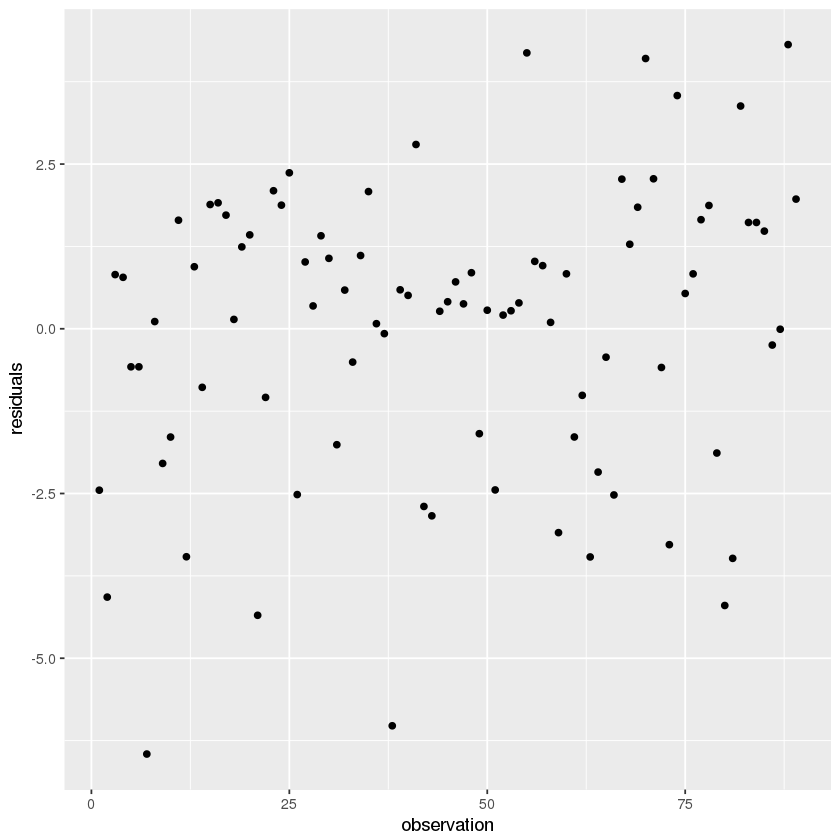

In [11]:
df <- data.frame(observation=1:length(resid(lms2)), residuals=resid(lms2))
ggplot(data=df, aes(observation,residuals)) + geom_point()

### Comparison of actual to predicted costs/m2
Result does not look too bad for a simple linear model. Still, applicability of the linear model for the cluster towards the origin needs some closer investigation.

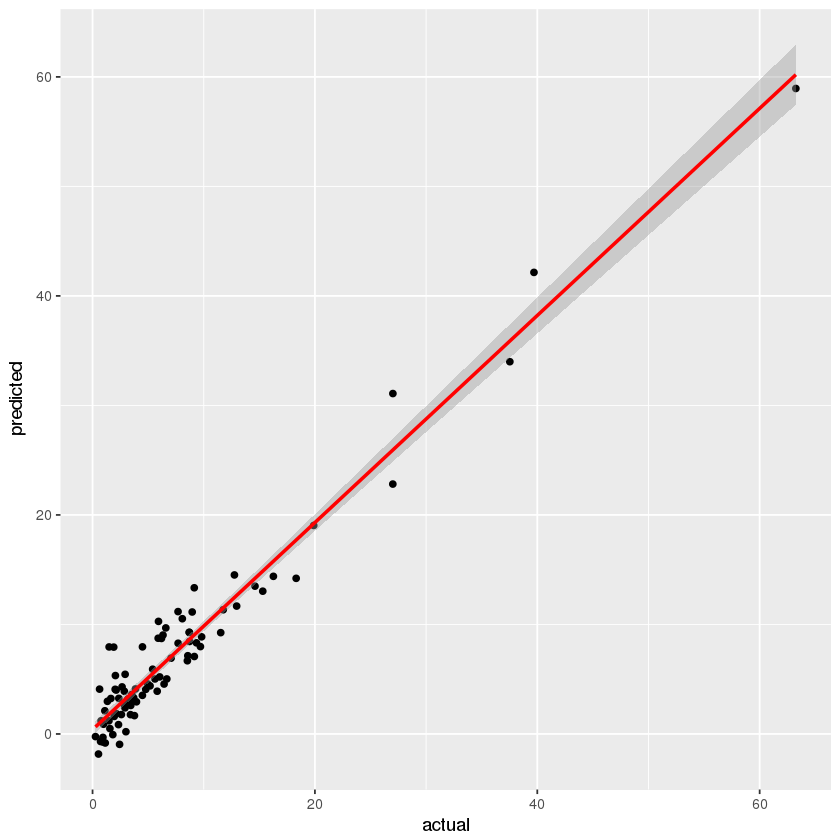

In [12]:
df <- data.frame(actual=bp.lm.no$Costsm2, predicted=predict(lms2))
ggplot(data=df, aes(actual,predicted)) + geom_point() + stat_smooth(method = "lm", col = "red")

## Machine Learning with Spark: Linear Model with SparkR::glm()
The procedure is similar to the steps outlined above, with two important differences
- The data is instanciated as a SparkDataFrame (as opposed to a base R dataframe)
- The predictive model is calculated by a Spark aware variant on the DSX Spark cluster (as opposed to a local function in base R)
### Create SparkDataFrame from file on Object Storage
DSX provides code snippets to access files on ObjectStorage as a SparcDataFrame. Any operation on such a SparkDataFrame is carried out in the DSX Spark cluster. The cell below adds a custom function for easy access. Optionally a field type definition object (aka 'schema') can be provided.

In [13]:
# The code was removed by DSX for sharing.

### Custom function for data access

In [14]:
getObjectStorageFileAsSparkDataFrame <- function(container, file, schema=NULL) {
    df <- read.df(bmos$url(container, file),
    source = "org.apache.spark.sql.execution.datasources.csv.CSVFileFormat",
    header = "true", schema=schema)
    return(df)
}


In [15]:
### Use predefined data  types

In [16]:
# Costsm2	Age	Stores	Size	acPlugLoad	acAirCondition	gasDomestic	gasHeating	kWH	Long	Lat
schema <- structType(
    structField("Costsm2", "double"),
    structField("Age", "integer"),
    structField("Stores", "integer"),
    structField("Size", "double"),
    structField("acPlugLoad", "double"),
    structField("acAirCondition", "double"),
    structField("gasDomestic", "double"),
    structField("gasHeating", "double"),
    structField("kWH", "double"),
    structField("Long", "double"),
    structField("Lat", "double")
    )

In [17]:
bp.sdf <-  getObjectStorageFileAsSparkDataFrame("WDPDSX", "BP-lm.csv",schema)
class(bp.sdf)
printSchema(bp.sdf)
head(bp.sdf,5)

[1] "SparkDataFrame"
attr(,"package")
[1] "SparkR"

root
 |-- Costsm2: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Stores: integer (nullable = true)
 |-- Size: double (nullable = true)
 |-- acPlugLoad: double (nullable = true)
 |-- acAirCondition: double (nullable = true)
 |-- gasDomestic: double (nullable = true)
 |-- gasHeating: double (nullable = true)
 |-- kWH: double (nullable = true)
 |-- Long: double (nullable = true)
 |-- Lat: double (nullable = true)


Costsm2,Age,Stores,Size,acPlugLoad,acAirCondition,gasDomestic,gasHeating,kWH,Long,Lat
8.073288,62,4,14600,11.651406,0.9835313,0.09622646,0.36619324,117870,-73.94733,40.79192
27.011666,77,1,600,32.769884,5.0083719,0.18584352,0.02961357,16207,-73.89331,40.72744
2.594000,97,2,6000,2.345049,0.2961338,0.03270597,0.03646070,15564,-74.09870,40.64298
5.170200,52,1,5000,4.618817,0.7651886,0.02750427,0.23466382,25851,-73.74700,40.62267
8.700699,53,2,26318,7.108797,1.8631277,0.02915642,0.56072095,228985,-73.90963,40.61887


### Run linear model in Spark cluster

In [18]:
selCols <- c("Costsm2","Age","Stores","Size","acPlugLoad","acAirCondition","gasDomestic","gasHeating","kWH")
bp.sdf.lm <- bp.sdf[,selCols]

glm <- spark.glm(data=bp.sdf.lm, formula = Costsm2~.)
SparkR::summary(glm)


Deviance Residuals: 
(Note: These are approximate quantiles with relative error <= 0.01)
    Min       1Q   Median       3Q      Max  
-14.437   -2.214   -0.526    1.661   35.346  

Coefficients:
                Estimate     Std. Error  t value   Pr(>|t|)  
(Intercept)     1.4614       2.6096      0.56003   0.57695   
Age             0.036502     0.019808    1.8428    0.068892  
Stores          -1.1753      0.64628     -1.8185   0.072551  
Size            -0.00042977  0.00014864  -2.8914   0.0048811 
acPlugLoad      0.85638      0.090596    9.4527    7.3275e-15
acAirCondition  -0.2982      0.58886     -0.50641  0.6139    
gasDomestic     2.3796       3.3545      0.70938   0.48005   
gasHeating      -1.2787      1.3705      -0.93297  0.35351   
kWH             6.7473e-05   1.8011e-05  3.7462    0.00032831

(Dispersion parameter for gaussian family taken to be 27.13292)

    Null deviance: 11782.9  on 92  degrees of freedom
Residual deviance:  2279.2  on 84  degrees of freedom
AIC: 581.

## Create SparkDataFrame from table in dashDB

In [19]:
# The code was removed by DSX for sharing.

### Custom function for data access

In [20]:

getDashDBTableAsSparkDataFrame <- function(dbschema, table) {
    df <- read.jdbc(url = properties.5f358061e3814704b61435f96bf31a94$jdbcurl, table = paste(dbschema,table,sep="."), user = properties.5f358061e3814704b61435f96bf31a94$username, password = properties.5f358061e3814704b61435f96bf31a94$password)
    return(df)
}

In [21]:
df.sdf <- getDashDBTableAsSparkDataFrame("DASH015537","BLOCPOWER_LM")
class(df.sdf)
head(df.sdf,5)

[1] "SparkDataFrame"
attr(,"package")
[1] "SparkR"

Costsm2,Age,Stores,Size,acPlugLoad,acAirCondition,gasDomestic,gasHeating,kWH,Long,Lat
8.073288,62,4,14600,11.651406,0.9835313,0.09622646,0.36619324,117870,-73.94733,40.79192
27.011666,77,1,600,32.769884,5.0083719,0.18584352,0.02961357,16207,-73.89331,40.72744
2.594000,97,2,6000,2.345049,0.2961338,0.03270597,0.03646070,15564,-74.09870,40.64298
5.170200,52,1,5000,4.618817,0.7651886,0.02750427,0.23466382,25851,-73.74700,40.62267
8.700699,53,2,26318,7.108797,1.8631277,0.02915642,0.56072095,228985,-73.90963,40.61887


### Calcuate linear model in Spark Cluster

In [22]:
selCols <- c("Costsm2","Age","Stores","Size","acPlugLoad","acAirCondition","gasDomestic","gasHeating","kWH")
bp.sdf.lm <- bp.sdf[,selCols]

glm <- spark.glm(data=bp.sdf.lm, formula = Costsm2~.)
class(glm)
SparkR::summary(glm)

[1] "GeneralizedLinearRegressionModel"
attr(,"package")
[1] "SparkR"


Deviance Residuals: 
(Note: These are approximate quantiles with relative error <= 0.01)
    Min       1Q   Median       3Q      Max  
-14.437   -2.214   -0.526    1.661   35.346  

Coefficients:
                Estimate     Std. Error  t value   Pr(>|t|)  
(Intercept)     1.4614       2.6096      0.56003   0.57695   
Age             0.036502     0.019808    1.8428    0.068892  
Stores          -1.1753      0.64628     -1.8185   0.072551  
Size            -0.00042977  0.00014864  -2.8914   0.0048811 
acPlugLoad      0.85638      0.090596    9.4527    7.3275e-15
acAirCondition  -0.2982      0.58886     -0.50641  0.6139    
gasDomestic     2.3796       3.3545      0.70938   0.48005   
gasHeating      -1.2787      1.3705      -0.93297  0.35351   
kWH             6.7473e-05   1.8011e-05  3.7462    0.00032831

(Dispersion parameter for gaussian family taken to be 27.13292)

    Null deviance: 11782.9  on 92  degrees of freedom
Residual deviance:  2279.2  on 84  degrees of freedom
AIC: 581.

## Spark MLlib (SparkR)

Classification
- spark.logit: Logistic Regression
- spark.mlp: Multilayer Perceptron (MLP)
- spark.naiveBayes: Naive Bayes
- spark.svmLinear: Linear Support Vector Machine

Regression
- spark.survreg: Accelerated Failure Time (AFT) Survival Model
- spark.glm or glm: Generalized Linear Model (GLM)
- spark.isoreg: Isotonic Regression

Tree
- spark.gbt: Gradient Boosted Trees for Regression and Classification
- spark.randomForest: Random Forest for Regression and Classification

Clustering
- spark.bisectingKmeans: Bisecting k-means
- spark.gaussianMixture: Gaussian Mixture Model (GMM)
- spark.kmeans: K-Means
- spark.lda: Latent Dirichlet Allocation (LDA)

Collaborative Filtering
- spark.als: Alternating Least Squares (ALS)

Frequent Pattern Mining
- spark.fpGrowth : FP-growth

Statistics
- spark.kstest: Kolmogorov-Smirnov Test


## Buildings for immediate investigation

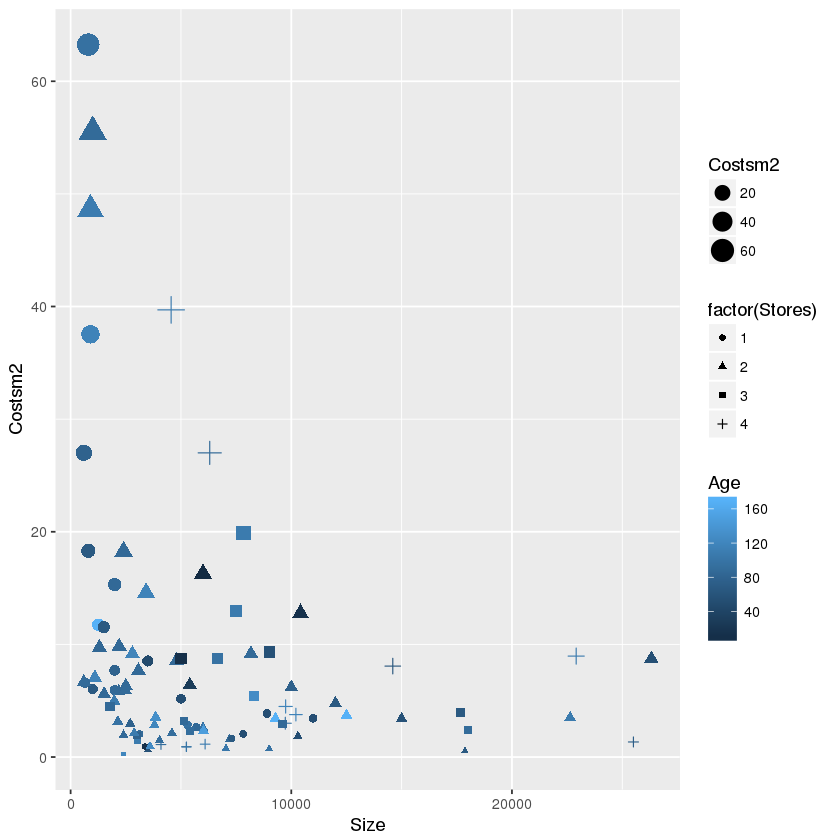

In [23]:
ggplot(data=bp, aes(Size,Costsm2, col=Age, shape=factor(Stores), size=Costsm2)) + geom_point()

## Unsupervised learning: classification by kmeans clustering
In the section above a subjective identification of buildings with non-standard features was based on a single plot. A more systematic approach to identify structures in the data is the domain of 'unsupervised learning'. kmeans is a popular method to find clusters of observations with similar features. The number of clusters to search for is required as input.

In the cell below the Spark variant of the kmeans algorithm is used, that is, the calculations are carried out on the Spark cluster and results returned to the notebook.

Caveat: For kmeans clustering the data must be scaled for similar weight of feature. For simplicity this step is left out here. As a consequence, clustering results may biased towards features with high range of values.

In [24]:
# spark.kmeans(data = df, formula = ~ lat + lon, ...)
selCols <- c("Costsm2","Age","Stores","Size","acPlugLoad","acAirCondition","gasDomestic","gasHeating","kWH")
bp.sdf.kmeans <- bp.sdf[,selCols]

model.kmeans <- spark.kmeans(bp.sdf.kmeans, formula = ~ ., k = 3, initMode = "random")
class(model.kmeans)

[1] "KMeansModel"
attr(,"package")
[1] "SparkR"

### Prediction
Using the kmeans model just established each observation is classified by method 'prediction'.

In [25]:
# fitted values on training data
fitted.kmeans <- SparkR::predict(model.kmeans, bp.sdf.kmeans)
str(fitted.kmeans)
head(fitted.kmeans)

'SparkDataFrame': 10 variables:
 $ Costsm2       : num 8.07328766438356 27.0116663666667 2.59399996833333 5.170199982 8.70069914507181 8.70069914507181
 $ Age           : int 62 77 97 52 53 53
 $ Stores        : int 4 1 2 1 2 2
 $ Size          : num 14600 600 6000 5000 26318 26318
 $ acPlugLoad    : num 11.65140596 32.76988438 2.345049272 4.618817159 7.108796544 7.108796544
 $ acAirCondition: num 0.983531348 5.008371873 0.296133819 0.765188561 1.863127708 1.863127708
 $ gasDomestic   : num 0.096226455 0.185843516 0.032705972 0.02750427 0.029156422 0.029156422
 $ gasHeating    : num 0.366193236 0.029613568 0.036460695 0.23466382 0.560720947 0.560720947
 $ kWH           : num 117869.9999 16206.99982 15563.99981 25850.99991 228985.0001 228985.0001
 $ prediction    : int 2 1 1 1 2 2


Costsm2,Age,Stores,Size,acPlugLoad,acAirCondition,gasDomestic,gasHeating,kWH,prediction
8.073288,62,4,14600,11.651406,0.9835313,0.09622646,0.36619324,117870,2
27.011666,77,1,600,32.769884,5.0083719,0.18584352,0.02961357,16207,1
2.594000,97,2,6000,2.345049,0.2961338,0.03270597,0.03646070,15564,1
5.170200,52,1,5000,4.618817,0.7651886,0.02750427,0.23466382,25851,1
8.700699,53,2,26318,7.108797,1.8631277,0.02915642,0.56072095,228985,2
8.700699,53,2,26318,7.108797,1.8631277,0.02915642,0.56072095,228985,2


### Visualize results
The size and costs/m2 is used to visualize the classification. 

In [26]:
bp.df.kmeans <- SparkR::as.data.frame(bp.sdf)
bp.df.kmeans$prediction <- factor(SparkR::as.data.frame(fitted.kmeans)[,"prediction"])
str(bp.df.kmeans)
head(bp.df.kmeans,1)

'data.frame':	93 obs. of  12 variables:
 $ Costsm2       : num  8.07 27.01 2.59 5.17 8.7 ...
 $ Age           : int  62 77 97 52 53 53 107 120 86 86 ...
 $ Stores        : int  4 1 2 1 2 2 3 2 2 1 ...
 $ Size          : num  14600 600 6000 5000 26318 ...
 $ acPlugLoad    : num  11.65 32.77 2.35 4.62 7.11 ...
 $ acAirCondition: num  0.984 5.008 0.296 0.765 1.863 ...
 $ gasDomestic   : num  0.0962 0.1858 0.0327 0.0275 0.0292 ...
 $ gasHeating    : num  0.3662 0.0296 0.0365 0.2347 0.5607 ...
 $ kWH           : num  117870 16207 15564 25851 228985 ...
 $ Long          : num  -73.9 -73.9 -74.1 -73.7 -73.9 ...
 $ Lat           : num  40.8 40.7 40.6 40.6 40.6 ...
 $ prediction    : Factor w/ 3 levels "0","1","2": 3 2 2 2 3 3 2 2 1 2 ...


Costsm2,Age,Stores,Size,acPlugLoad,acAirCondition,gasDomestic,gasHeating,kWH,Long,Lat,prediction
8.073288,62,4,14600,11.65141,0.9835313,0.09622646,0.3661932,117870,-73.94733,40.79192,2


Inspection of results shows the three classes of buildings found by kmeans are located in three 'stripes' in the size vs. costsm2 feature space. As indicated before the data are biased by features with big values (e.g. kWH and Size), so the clustering is for demonstration purposes only.

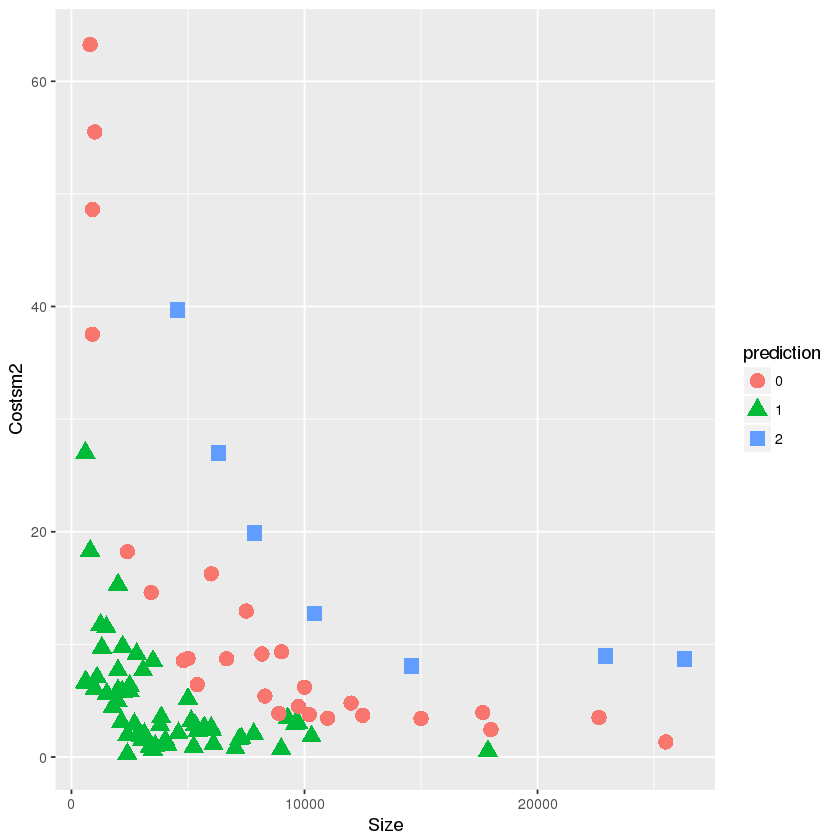

In [27]:
ggplot(data=bp.df.kmeans, aes(Size, Costsm2, shape=prediction, col=prediction)) + geom_point(size=4)

## Conclusion
This notebook has demonstrated how data in object storage and dashDB can be used for analytics in standard R and SparkR.  